In [1]:
import os
from river import datasets
from river import metrics
from river import tree
from river import ensemble
from river import evaluate
from river import compose
from river import naive_bayes
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from confluent_kafka import Producer,Consumer
import certifi
import time
import json
import pandas

In [2]:
classifiers=[]
classifier='HoeffdingAdaptiveTreeClassifier'
classifiers.append(classifier)
classifier='SRPClassifierHAT'
classifiers.append(classifier)
classifier='SRPClassifierNaiveBayes'
classifiers.append(classifier)
classifier='AdaptiveRandomForestClassifier'
classifiers.append(classifier)
#classifier='HalfSpaceTrees'
#classifiers.append(classifier)
model_artifact = None

In [3]:
max_size=1000
dataset = datasets.MaliciousURL()
d_train=[]
d_predict=[]
d_total=[]
for classifier in classifiers:
    data = dataset.take(max_size)
    if classifier=='HoeffdingAdaptiveTreeClassifier':
            model_artifact = tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,  delta=1e-5, leaf_prediction='nb', nb_threshold=10,seed=0)
    elif classifier=='SRPClassifierHAT':
            model_artifact =  ensemble.SRPClassifier(
                                                   model=tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,  delta=1e-5, leaf_prediction='nb', nb_threshold=10, seed=0), seed=42,
                                                )
    elif classifier=='SRPClassifierNaiveBayes':
            model_artifact = ensemble.SRPClassifier(
                                                 model=naive_bayes.BernoulliNB(alpha=1), seed=42,
                                              )
    elif classifier=='AdaptiveRandomForestClassifier':
            model_artifact = ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")

#    elif classifier=='HalfSpaceTrees':
#            model_artifact = compose.Pipeline(preprocessing.MinMaxScaler(),anomaly.HalfSpaceTrees(seed=42))
    print(model_artifact)
    cnt = 0
    training_st_ts = time.time()
    for f, y in data:
        cnt = cnt + 1
        model_artifact = model_artifact.learn_one(f,y)
    training_end_ts = time.time()
    total_training_duration = training_end_ts-training_st_ts
    avg_duration = (total_training_duration/max_size)     
    d_train.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max Training Throughput (sub-second-response) ': round(1/avg_duration)})
    
    data = dataset.take(max_size)
    prediction_st_ts = time.time()
    for f, y in data:
        cnt = cnt + 1
        if classifier=='HalfSpaceTrees':
            model_artifact.learn_one(f)
        else:
            model_artifact.predict_one(f)
    prediction_end_ts = time.time()
    total_prediction_duration = prediction_end_ts-prediction_st_ts
    avg_duration = (total_prediction_duration/max_size)     
    d_predict.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max Prediction Throughput (sub-second-response) ': round(1/avg_duration)})

    total_duration = total_training_duration + total_prediction_duration
    avg_duration = (total_duration/max_size)     
    d_total.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max (Training+Prediction) Throughput (sub-second-response) ': round(1/avg_duration)})



HoeffdingAdaptiveTreeClassifier
Uncompressing into /home/ubuntu/river_data/MaliciousURL
SRPClassifier(HoeffdingAdaptiveTreeClassifier)
SRPClassifier(BernoulliNB)
AdaptiveRandomForestClassifier


In [5]:
print('Training')
df_train = pandas.DataFrame(data=d_train)
display(df_train)

print('Prediction')
df_predict = pandas.DataFrame(data=d_predict)
display(df_predict)

print('Total')
df_total = pandas.DataFrame(data=d_total)
display(df_total)

Training


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max Training Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,14.173166,14173.165560,236.219426,71
1,SRPClassifierHAT,37.544309,37544.309378,625.738490,27
2,SRPClassifierNaiveBayes,6.400703,6400.702715,106.678379,156
3,AdaptiveRandomForestClassifier,1.328327,1328.326941,22.138782,753


Prediction


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max Prediction Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,0.747721,747.721195,12.462020,1337
1,SRPClassifierHAT,1.592231,1592.231274,26.537188,628
2,SRPClassifierNaiveBayes,1.681467,1681.467295,28.024455,595
3,AdaptiveRandomForestClassifier,0.246020,246.019840,4.100331,4065


Total


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max (Training+Prediction) Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,14.920887,14920.886755,248.681446,67
1,SRPClassifierHAT,39.136541,39136.540651,652.275678,26
2,SRPClassifierNaiveBayes,8.082170,8082.170010,134.702833,124
3,AdaptiveRandomForestClassifier,1.574347,1574.346781,26.239113,635


<AxesSubplot: >

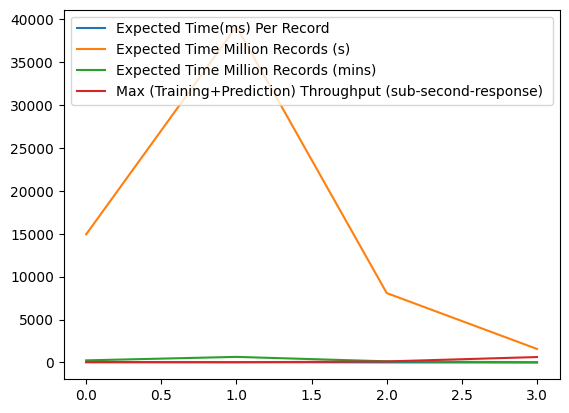

In [7]:
df_total.plot()